# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
train_dir = "/content/drive/MyDrive/Dataset/archive/Training/"
test_dir = "/content/drive/MyDrive/Dataset/archive/Testing/"

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(train_dir, IMG_SIZE)
X_test, y_test, _ = load_data(test_dir, IMG_SIZE)

xtest = X_test

100%|██████████| 4/4 [02:25<00:00, 36.33s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



5712 images loaded from /content/drive/MyDrive/Dataset/archive/Training/ directory.


100%|██████████| 4/4 [00:22<00:00,  5.74s/it]

1311 images loaded from /content/drive/MyDrive/Dataset/archive/Testing/ directory.


In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)
    return np.array(set_new)

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Dataset/archive/Training/meningioma/Tr-me_0018.jpg')
IMG_SIZE = (224,224)
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

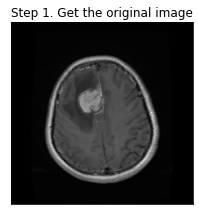

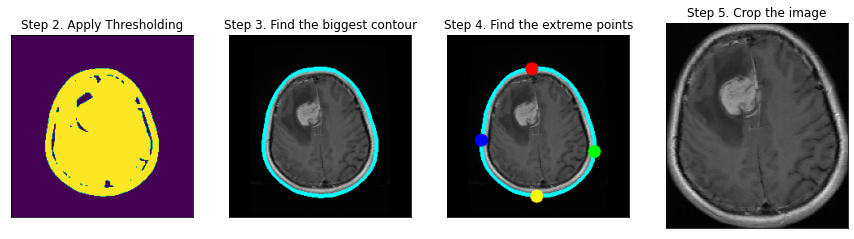

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(thresh)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Apply Thresholding')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 5. Crop the image')
plt.show()

In [ ]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1

        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

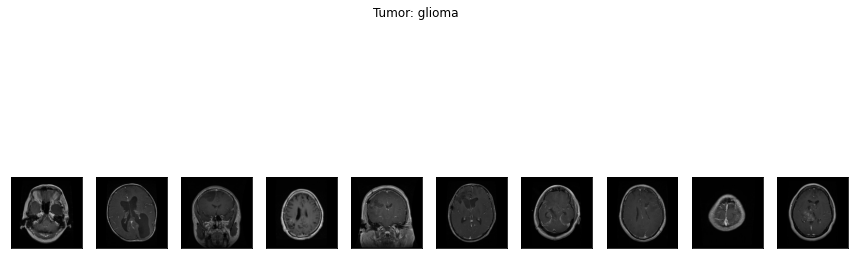

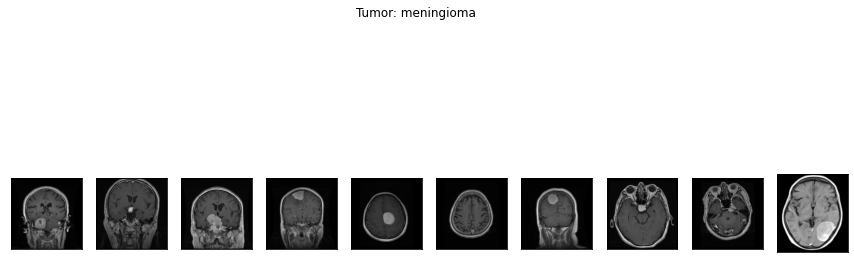

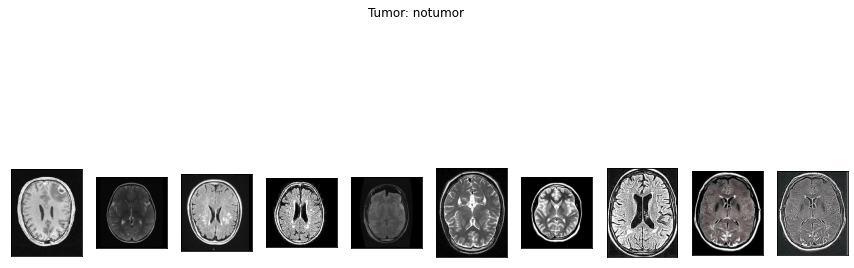

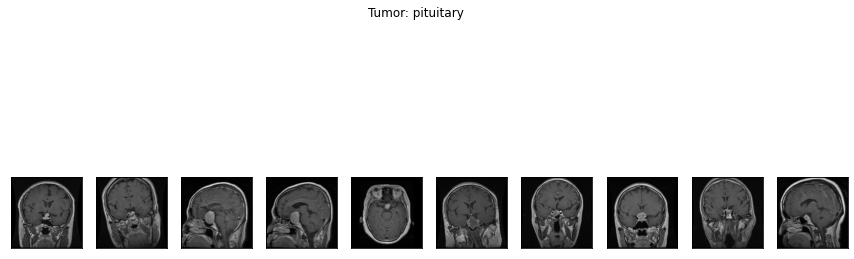

In [ ]:
#Orginal Images
plot_samples(X_train, y_train, labels, 10)

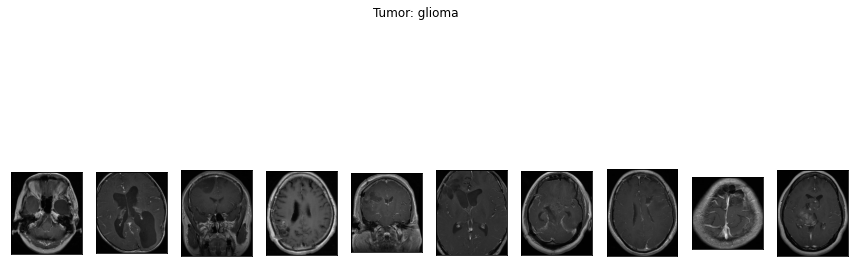

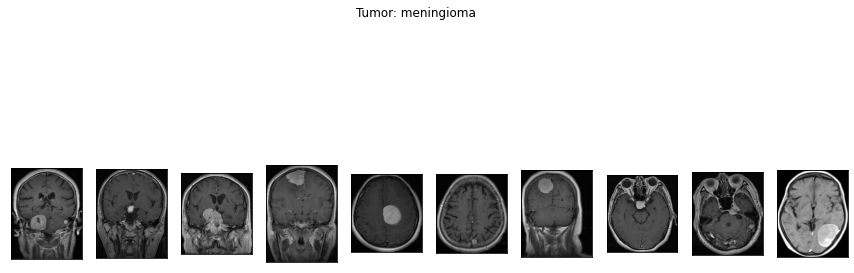

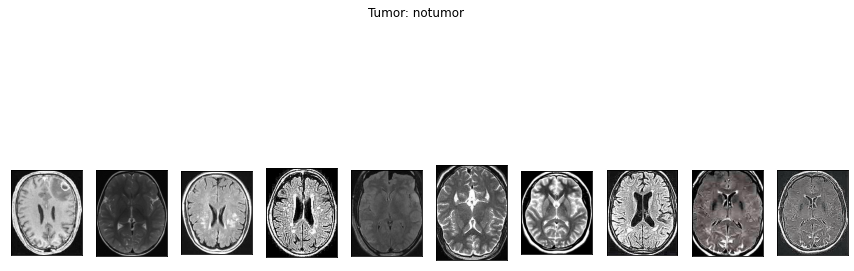

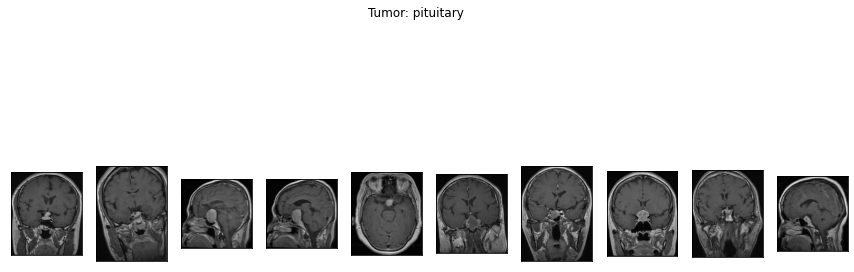

In [ ]:
#After applying all images
plot_samples(X_train_crop, y_train, labels, 10)

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)

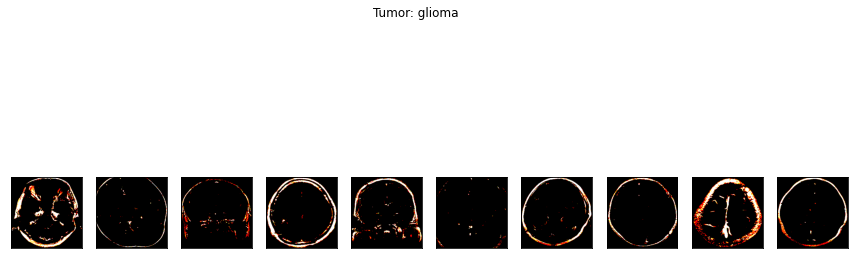

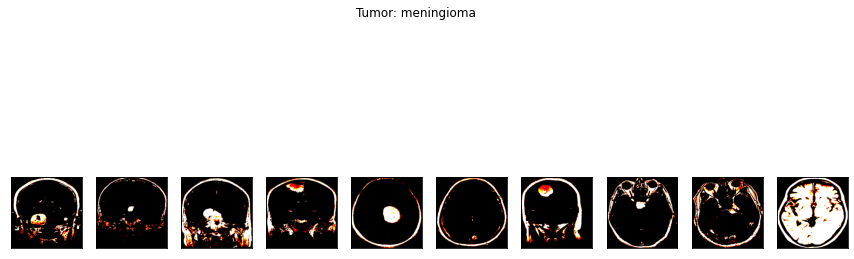

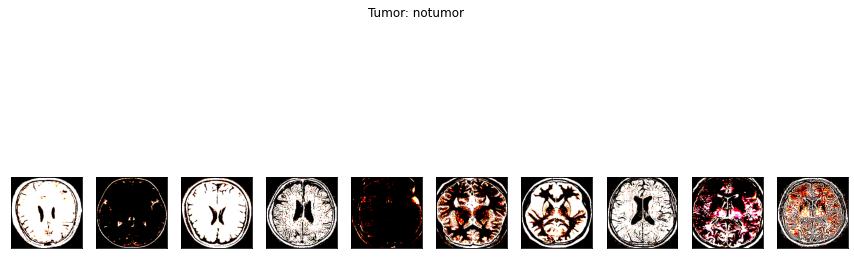

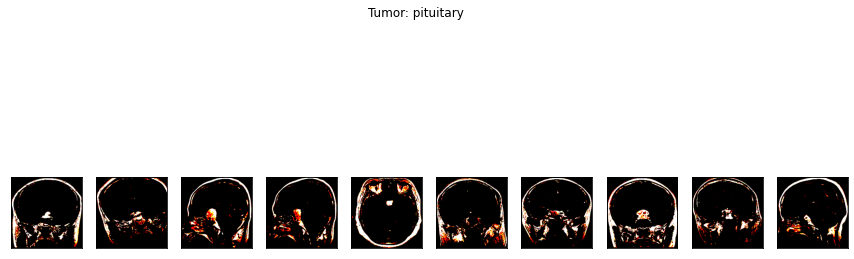

In [ ]:
 plot_samples(X_train_prep, y_train, labels, 10)

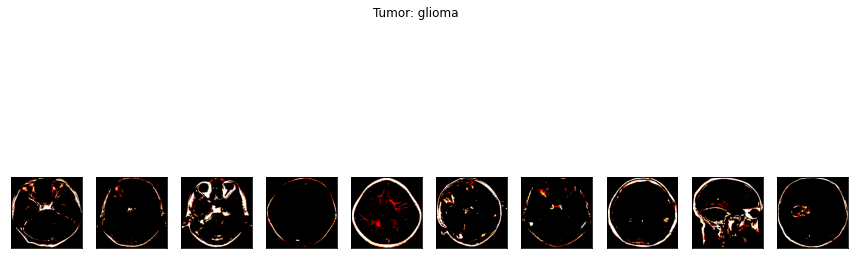

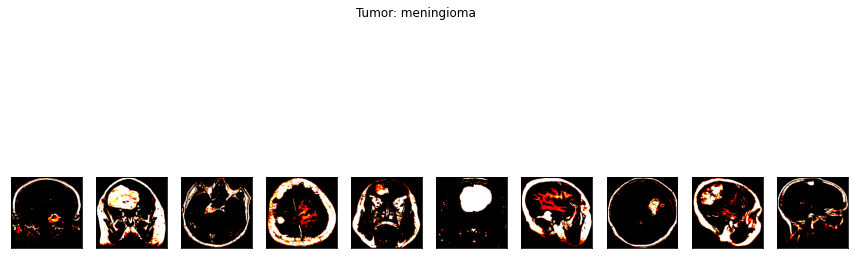

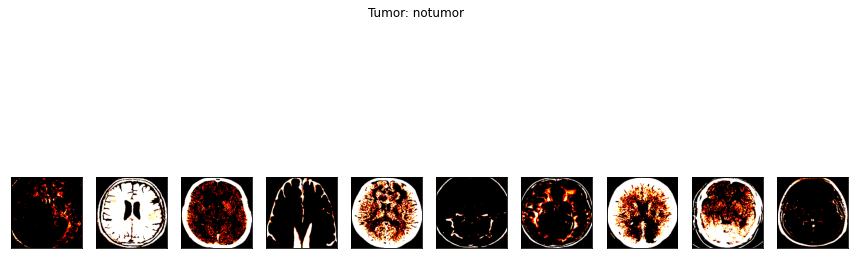

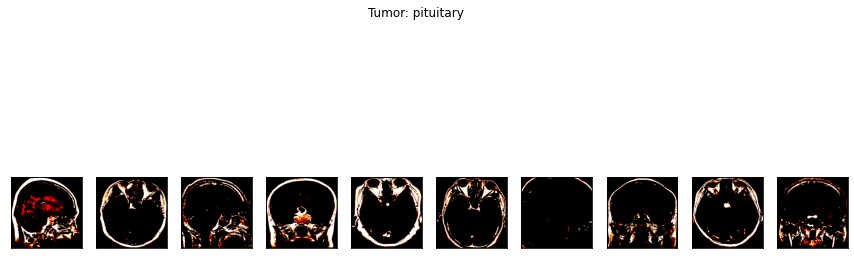

In [ ]:
 plot_samples(X_test_prep, y_test, labels, 10)

In [ ]:
X_train_prep.shape

(5712, 224, 224, 3)

In [ ]:
X_test_prep.shape

(1311, 224, 224, 3)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'glioma/'+str(i)+'.jpg', img)
        elif imclass == 1:
            cv2.imwrite(folder_name+'meningioma/'+str(i)+'.jpg', img)
        elif imclass == 2:
            cv2.imwrite(folder_name+'notumor/'+str(i)+'.jpg', img)
        elif imclass == 3:
            cv2.imwrite(folder_name+'pituitary/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
"""
# saving new images to the folder
!mkdir /content/drive/MyDrive/Dataset/TRAIN_PRE /content/drive/MyDrive/Dataset/TEST_PRE /content/drive/MyDrive/Dataset/TRAIN_PRE/glioma /content/drive/MyDrive/Dataset/TRAIN_PRE/meningioma /content/drive/MyDrive/Dataset/TRAIN_PRE/notumor /content/drive/MyDrive/Dataset/TRAIN_PRE/pituitary /content/drive/MyDrive/Dataset/TEST_PRE/glioma /content/drive/MyDrive/Dataset/TEST_PRE/meningioma /content/drive/MyDrive/Dataset/TEST_PRE/notumor /content/drive/MyDrive/Dataset/TEST_PRE/pituitary

save_new_images(X_train_prep, y_train, folder_name='/content/drive/MyDrive/Dataset/TRAIN_PRE/')
save_new_images(X_test_prep, y_test, folder_name='/content/drive/MyDrive/Dataset/TEST_PRE/')
"""

"\n# saving new images to the folder\n!mkdir /content/drive/MyDrive/Dataset/TRAIN_PRE /content/drive/MyDrive/Dataset/TEST_PRE /content/drive/MyDrive/Dataset/TRAIN_PRE/glioma /content/drive/MyDrive/Dataset/TRAIN_PRE/meningioma /content/drive/MyDrive/Dataset/TRAIN_PRE/notumor /content/drive/MyDrive/Dataset/TRAIN_PRE/pituitary /content/drive/MyDrive/Dataset/TEST_PRE/glioma /content/drive/MyDrive/Dataset/TEST_PRE/meningioma /content/drive/MyDrive/Dataset/TEST_PRE/notumor /content/drive/MyDrive/Dataset/TEST_PRE/pituitary\n\nsave_new_images(X_train_prep, y_train, folder_name='/content/drive/MyDrive/Dataset/TRAIN_PRE/')\nsave_new_images(X_test_prep, y_test, folder_name='/content/drive/MyDrive/Dataset/TEST_PRE/')\n"

In [ ]:
train_dir = "/content/drive/MyDrive/Dataset/TRAIN_PRE/"
test_dir = "/content/drive/MyDrive/Dataset/TEST_PRE/"

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(train_dir, IMG_SIZE)
X_test, y_test, _ = load_data(test_dir, IMG_SIZE)

100%|██████████| 4/4 [01:50<00:00, 27.62s/it]


5712 images loaded from /content/drive/MyDrive/Dataset/TRAIN_PRE/ directory.


100%|██████████| 4/4 [00:16<00:00,  4.23s/it]

1311 images loaded from /content/drive/MyDrive/Dataset/TEST_PRE/ directory.


In [ ]:
X_train.shape

(5712, 224, 224, 3)

In [ ]:
y_train.shape

(5712,)

In [ ]:
import tensorflow as tf

In [ ]:
model1 = Sequential()

# Convolutional layer 1
model1.add(Conv2D(32,(3,3), input_shape=(64, 64, 1), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 2
model1.add(Conv2D(32,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Neural network

model1.add(Dense(units= 252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=4, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])


# using the ImageDataGenerator to prepare the images (Resize, nomalize, etc)

generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)


# Creating the train and test data.

train = generator_train.flow_from_directory('/content/drive/MyDrive/Dataset/TRAIN_PRE/', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory('/content/drive/MyDrive/Dataset/TEST_PRE/', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Creating callbacks for the model.
# If the model dosen't continue to improve (loss), the trainning will stop.

# Stop training if loss doesn't keep decreasing.
model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = 'model1_weights.h5', monitor = 'val_categorical_accuracy',
                      save_best_only = True, verbose = 1)

# Fiting the model.
history1 = model1.fit(train, steps_per_epoch=5712//32, epochs=100, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model1_es, model1_rlr, model1_mcp])

Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 1.0926 - categorical_accuracy: 0.6264
Epoch 1: val_categorical_accuracy improved from -inf to 0.31094, saving model to model1_weights.h5
178/178 [==============================] - 35s 191ms/step - loss: 1.0926 - categorical_accuracy: 0.6264 - val_loss: 5.0709 - val_categorical_accuracy: 0.3109 - lr: 0.0010
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 0.6490 - categorical_accuracy: 0.7461
Epoch 2: val_categorical_accuracy improved from 0.31094 to 0.31250, saving model to model1_weights.h5
178/178 [==============================] - 33s 187ms/step - loss: 0.6490 - categorical_accuracy: 0.7461 - val_loss: 3.9392 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 0.4875 - categorical_accuracy: 0.8192
Epoch 3: val_categorical_accuracy improved from 0.31250 to 0.46328, saving model to model1_weights.h5
178/178 [===================

In [ ]:
model1.evaluate(test)

41/41 [==============================] - 5s 119ms/step - loss: 0.2129 - categorical_accuracy: 0.9626


[0.21291720867156982, 0.9626239538192749]

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 32)       128       
 hNormalization)                                                 
                                                        